In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2 
import os


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Load the dataset**

In [2]:
import os
import cv2
import numpy as np

def load_dataset(path_dataset, target_size=(125, 125)): 
    dataset = []
    labels = []

    # Iterate over all folders in dataset_path
    for label in os.listdir(path_dataset):
        class_path = os.path.join(path_dataset, label)

        # check if the directory exists
        if os.path.isdir(class_path):
            # Initialize a counter for images in each class
            images_counter = 0
            
            # Iterate over all images in folder/class
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)

                # Load image with OpenCV
                image = cv2.imread(image_path)

                # Check if the image was loaded successfully
                if image is not None:
                    # Resize the image
                    image = cv2.resize(image, target_size)

                    # Add image and label to dataset
                    dataset.append(image)
                    labels.append(label)


                else:
                    print(f"Error loading image: {image_path}")

    return np.array(dataset), np.array(labels)

dataset_path = "/kaggle/input/sugarcane-leaf-disease-dataset/"
dataset, labels = load_dataset(dataset_path) 

**Some dataset visualizations**

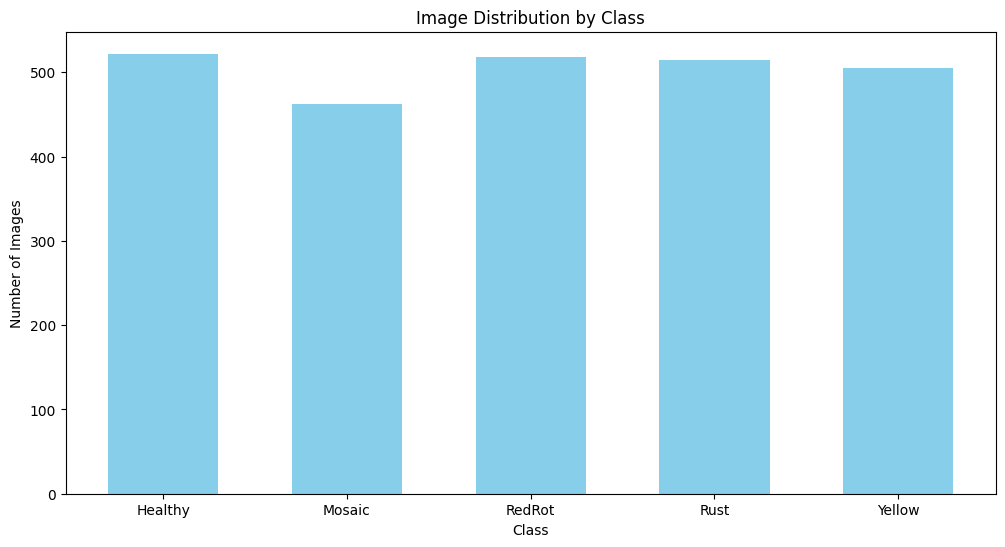

In [3]:
unique_labels, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique_labels, counts))

fig, ax = plt.subplots(figsize=(12, 6)) 
bars = ax.bar(class_counts.keys(), class_counts.values(), color='skyblue', width=0.6)  

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Image Distribution by Class')

plt.show()

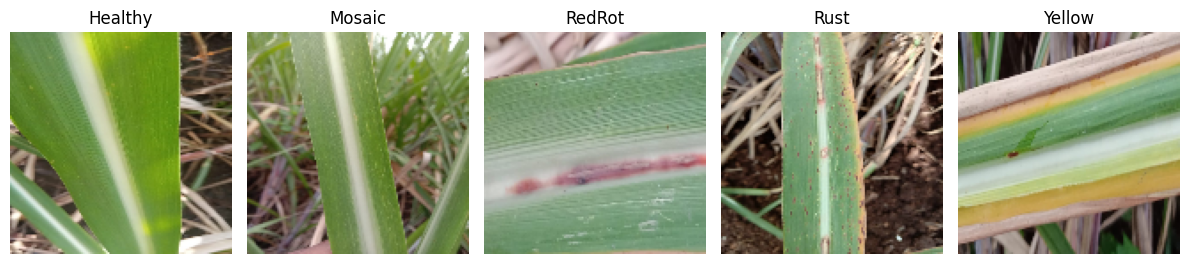

In [4]:
import random
import matplotlib.pyplot as plt

def show_samples(dataset, labels, classes, num_samples):
    plt.figure(figsize=(12, 6))
    
    for i, class_name in enumerate(classes[:num_samples]):  # Show only the first num_samples classes
        indices_class = np.where(labels == class_name)[0]
        sample_index = random.choice(indices_class)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(dataset[sample_index], cv2.COLOR_BGR2RGB))
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


unique_classes = np.unique(labels)
show_samples(dataset, labels, unique_classes, num_samples=5)

**Separation between training set and test set**

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels into numbers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(dataset, encoded_labels, test_size=0.2, random_state=42)


def preprocess_image(image):
    resized_image = cv2.resize(image, (125, 125))
    
    #Normalize values between 0 and 1
    normalized_image = resized_image / 255.0
    return normalized_image

# Apply preprocessing to training and testing sets
X_train = np.array([preprocess_image(image) for image in X_train])
X_test = np.array([preprocess_image(image) for image in X_test])

# Check the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2016, 125, 125, 3)
Shape of X_test: (505, 125, 125, 3)
Shape of y_train: (2016,)
Shape of y_test: (505,)


**Network Architecture (EfficientNet)**

In [6]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.2 MB/s eta 0:00:00


In [7]:
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np


num_classes = len(np.unique(labels))

model = models.Sequential()

efficientnet_model = EfficientNetB0(input_shape=(125, 125, 3), include_top=False, weights='imagenet', pooling='max')

model.add(efficientnet_model)

model.add(Dense(128, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(64, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(32, kernel_regularizer=l1(0.0001), activation='relu'))
model.add(BatchNormalization(renorm=True))
model.add(Dropout(0.3))

model.add(Dense(units=num_classes, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

custom_optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), callbacks=[early_stopping])

16804768/16804768 [==============================] - 0s 0us/step
Epoch 1/150


2024-02-02 17:31:35.524303: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


63/63 [==============================] - 40s 120ms/step - loss: 2.8662 - accuracy: 0.2371 - val_loss: 2.2342 - val_accuracy: 0.2911
Epoch 2/150
63/63 [==============================] - 5s 73ms/step - loss: 2.4602 - accuracy: 0.3105 - val_loss: 2.1962 - val_accuracy: 0.3386
Epoch 3/150
63/63 [==============================] - 5s 73ms/step - loss: 2.2489 - accuracy: 0.3993 - val_loss: 2.0791 - val_accuracy: 0.4158
Epoch 4/150
63/63 [==============================] - 5s 73ms/step - loss: 2.0163 - accuracy: 0.4633 - val_loss: 1.9615 - val_accuracy: 0.4713
Epoch 5/150
63/63 [==============================] - 5s 72ms/step - loss: 1.8877 - accuracy: 0.5248 - val_loss: 1.8175 - val_accuracy: 0.5287
Epoch 6/150
63/63 [==============================] - 5s 73ms/step - loss: 1.8009 - accuracy: 0.5605 - val_loss: 1.6488 - val_accuracy: 0.6020
Epoch 7/150
63/63 [==============================] - 5s 73ms/step - loss: 1.6027 - accuracy: 0.6295 - val_loss: 1.5142 - val_accuracy: 0.6733
Epoch 8/150
63/6

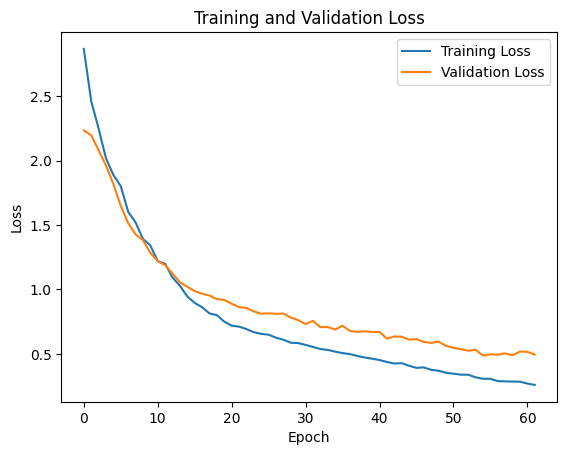

In [8]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

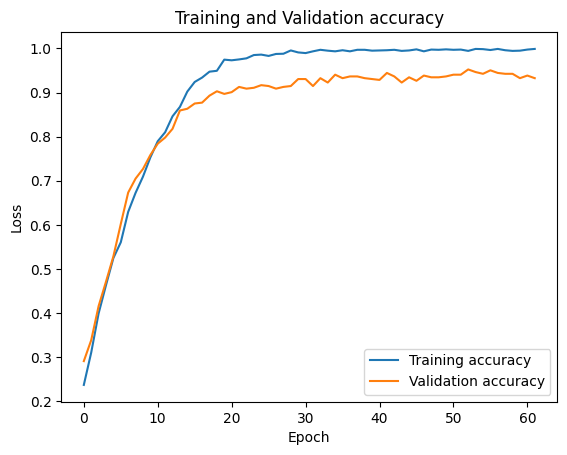

In [9]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Visualize predictions on the test set through the confusion matrix**

16/16 [==============================] - 2s 16ms/step


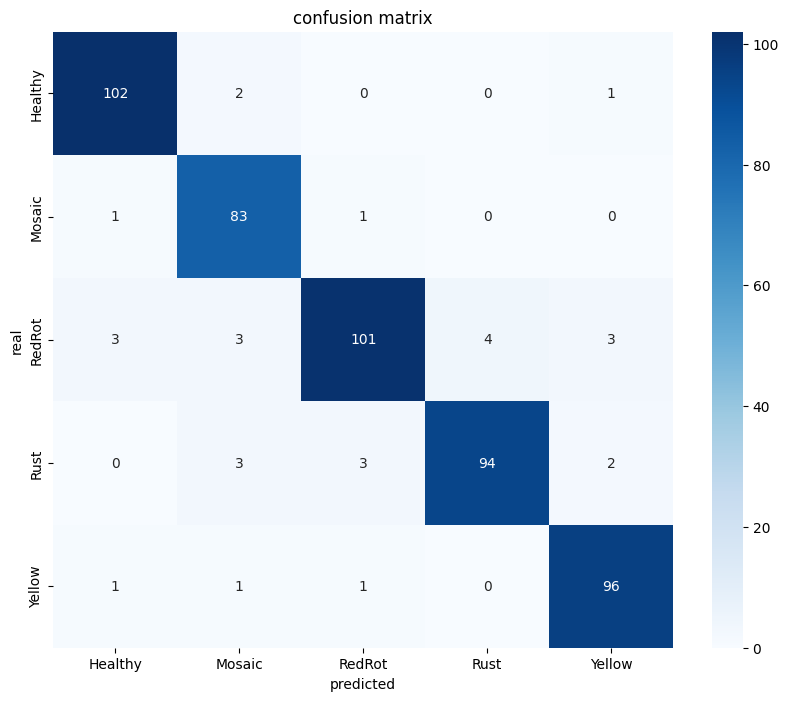

              precision    recall  f1-score   support

     Healthy       0.95      0.97      0.96       105
      Mosaic       0.90      0.98      0.94        85
      RedRot       0.95      0.89      0.92       114
        Rust       0.96      0.92      0.94       102
      Yellow       0.94      0.97      0.96        99

    accuracy                           0.94       505
   macro avg       0.94      0.95      0.94       505
weighted avg       0.94      0.94      0.94       505



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = y_test

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('real')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))